# 1. Chargement et exploration des données

## Téléchargement des datasets depuis Kaggle

In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import load_dotenv
import pandas as pd


def download_dataset(dataset_name, destination_dir="../data"):
    try:
        if not os.path.exists(destination_dir):
            os.makedirs(destination_dir)

        api.dataset_download_files(dataset_name, path=destination_dir, unzip=True)

    except Exception as e:
        print(f"Erreur lors du téléchargement : {e}")

load_dotenv()
os.environ['KAGGLE_USERNAME'] = os.getenv('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY')

api = KaggleApi()

try:
    api.authenticate()    
except Exception as e:
    print(f"Erreur d'authentification : {e}")

try:
    download_dataset("sumanthvrao/daily-climate-time-series-data")
except Exception as e:
    print(f"Erreur lors du téléchargement du dataset : {e}")

train_path = "../data/DailyDelhiClimateTrain.csv"
test_path = "../data/DailyDelhiClimateTest.csv"

try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
except FileNotFoundError as e:
    print(f"Erreur lors du chargement des fichiers : {e}")


Dataset URL: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data


Deux fichiers CSV ont été créés dans le dossier `data/` :

- `DailyDelhiClimateTest.csv`
- `DailyDelhiClimateTrain.csv`

Les deux fichiers possèdent les mêmes propriétés ; la seule différence réside dans leur taille. Le fichier `DailyDelhiClimateTrain.csv` est destiné à l'entraînement complet du modèle, tandis que le fichier `DailyDelhiClimateTest.csv`, plus réduit, servira a testé le modèle. Il y aura aussi une étape de validation les données utilisées pour cette étape seront reprises (20%) du dataset d'entraînement lors du prétraitement des données

### Apercu des fichiers

In [4]:
print("Aperçu fichier entrainement")
display(train_df.head())

print("Aperçu fichier de test")
display(test_df.head())

Aperçu fichier entrainement


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


Aperçu fichier de test


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


Nous nous intéresserons ici seulement à la colonne `meantemp`, qui représente la température moyenne.

Nous remarquons que les deux fichiers suivent le même format.

Nous remarquons aussi que le fichier de test n'est que la suite logique du fichier d'entraînement :  
le fichier d'entraînement se termine le 1er janvier 2017 et le fichier de test commence le même jour.

## Exploration des données

### Simplification des datasets

Afin de simplifier l'exploration des données, et étant donné que les deux fichiers sont successifs et suivent le même format, nous allons créer un dataset unique en plaçant le dataset de test à la suite du dataset d'entraînement.

Nous remarquons un premier problème : la dernière ligne du fichier d'entraînement, datée du 01/01/2017, n'est pas identique à la première ligne du fichier de test, également datée du 01/01/2017.


- Fin du fichier d'entrainement

In [22]:
print(train_df[["date", "meantemp"]].tail())

           date   meantemp
1457 2016-12-28  17.217391
1458 2016-12-29  15.238095
1459 2016-12-30  14.095238
1460 2016-12-31  15.052632
1461 2017-01-01  10.000000


- Début du fichier de test

In [20]:
print(test_df[["date", "meantemp"]].head())

         date   meantemp
0  2017-01-01  15.913043
1  2017-01-02  18.500000
2  2017-01-03  17.111111
3  2017-01-04  18.700000
4  2017-01-05  18.388889


On se rend vite compte que la ligne incorrecte est la dernière du dataset d'entraînement, avec une valeur parfaitement ronde qui n'a pas de sens si l'on regarde les températures précédentes et suivantes.

Nous pouvons donc maintenant :

- Supprimer la dernière ligne du fichier d'entraînement ;
- Créer un dataset global contenant la succession des deux datasets et l'enregistrer.

1. Suppression de la derniere ligne du fichier d'entrainement

In [24]:
df = pd.read_csv(train_path)

df = df[:-1]

df.to_csv(train_path, index=False)

2. Creer un dataset global

In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

global_df = pd.concat([train_df, test_df], ignore_index=True)

global_df.to_csv("../data/GlobalDataSet.csv", index=False)

### Valeurs manquantes

Voyons maintenant si des valeurs sont manquantes dans la colonne qui nous interesse : `meantemp`

In [30]:
isAnyValueMissing = global_df["meantemp"].isnull().any()

if isAnyValueMissing:
    print("Il y a au moins une valeur manquante")
else:
    print("La colonne ne contient aucune valeur manquante")

La colonne ne contient aucune valeur manquante


Nous remarquons donc aucune valeur manquante.

### Valeurs abérrantes

Voyons si des valeurs abérrantes se trouvent dans les fichiers commençons par analyser le minimum/maximum

#### Min/Max

In [31]:
print(global_df["meantemp"].describe())

count    1575.000000
mean       25.231582
std         7.337316
min         6.000000
25%        18.516667
50%        27.166667
75%        31.142857
max        38.714286
Name: meantemp, dtype: float64


Les températures varient entre `6°C` et `38.71°C`. Ces valeurs sont totalement plausible

#### Saut de valeur trop important

Il est aussi intéressant de vérifier s’il n'existe pas des sauts de valeur aberrants, comme par exemple un passage de `0°C` à `30°C` en une seule journée.

Commençons par analyser le saut le plus important.


In [32]:
diffs = global_df["meantemp"].diff().abs()
print("Max saut observé :", diffs.max())

Max saut observé : 10.625


On remarque dans le dataset un saut de `10°C` d’un jour à l’autre, ce qui semble important, bien que possible. Nous allons donc essayer d’examiner cela de plus près.

Commençons par analyser combien de fois ce type de saut se produit.  
Prenons dans un premier temps un seuil de `7°C`.

In [ ]:
seuil = 7

diffs = global_df["meantemp"].diff().abs()

nombre_sauts = (diffs > seuil).sum()

print(f"Nombre de sauts supérieurs à {seuil}°C : {nombre_sauts}")

Nombre de sauts supérieurs à 7°C : 2


Nous avons identifié deux valeurs présentant un saut important.  
C’est bon signe, car même s’il y a une ou deux erreurs, celles-ci n’affecteront pas significativement notre modèle.

Par curiosité, nous allons tout de même nous renseigner sur ces deux sauts.

Commençons par identifier les dates de ces deux sauts :


In [41]:
saut_indices = diffs[diffs > seuil].index

dates_sauts = global_df.loc[saut_indices, "date"]

for i in saut_indices:
    date = global_df.loc[i, "date"]
    valeur_saut = diffs.loc[i]
    print(f"{date} → saut de {valeur_saut:.2f}°C")

2015-06-25 → saut de 10.62°C
2015-07-06 → saut de 7.84°C


Bien que les sauts de température observés à New Delhi les 25 juin (+10,62°C) et 6 juillet 2015 (+7,84°C) soient impressionnants.

- L'écart de 7.84° semble bien réel
- L’écart du 25 juin est probablement surestimé avec une valeur réelle plus proche de 6–7°C
- Ce saut pourrait être dû à une mauvaise pondération de la moyenne journalière ou à des données influencées par des conditions météorologiques ponctuelles (il y avait de la pluie et certains disent un orage)).
- New Delhi étant une très grande métropole (plus de 1 400 km² les différences de température entre quartiers ainsi que l’origine exacte des mesures peuvent jouer un rôle important dans l’interprétation de ces données.

Sources :
- [Time and Date – Historique météo juin 2015 à New Delhi](https://www.timeanddate.com/weather/india/new-delhi/historic?month=6&year=2015)
- [Weather Underground – Historique quotidien 24 juin 2015](https://www.wunderground.com/history/weekly/in/new-delhi/VIDP/date/2015-6-24)

Nous ne modifierons pas la donnée, même si elle semble peu probable, car son **impact reste très limité**.

### Fréquence des données

In [42]:
global_df["date"] = pd.to_datetime(global_df["date"])

diffs = global_df["date"].diff()

print(diffs.value_counts())

date
1 days    1574
Name: count, dtype: int64


On remarque que la fréquence des données est constante, avec un intervalle d’un jour entre chaque enregistrement.
Cela signifie que le jeu de données est à **fréquence quotidienne**.

### Tendance

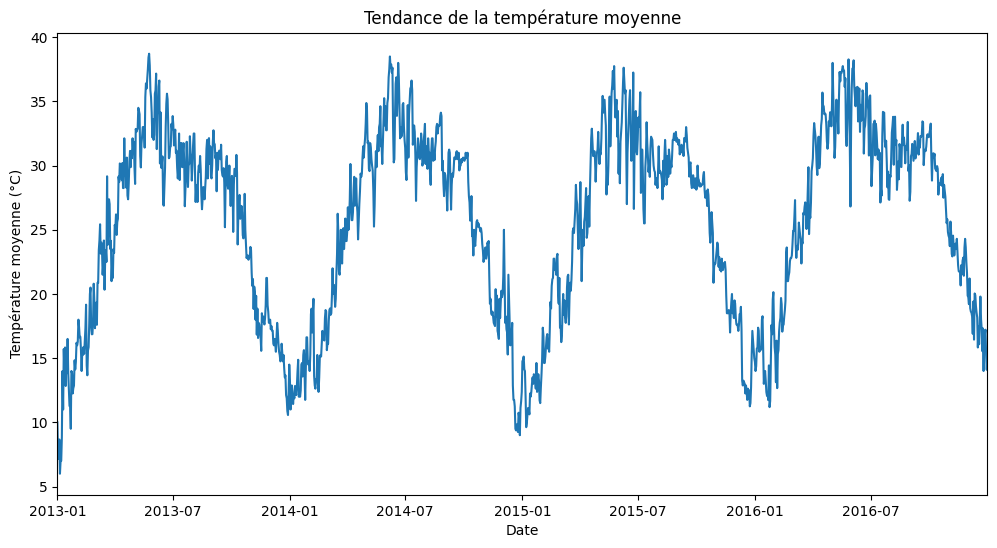

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Tracer
plt.figure(figsize=(12, 6))
plt.plot(global_df["date"], global_df["meantemp"])
plt.title("Tendance de la température moyenne")
plt.xlabel("Date")
plt.ylabel("Température moyenne (°C)")
plt.xlim(global_df["date"].min(), global_df["date"].max()) 
plt.show()


Le graphique de la température moyenne journalière met en évidence un cycle claire, avec une hausse progressive des températures au printemps, un pic en été, suivi d’une baisse en automne et en hiver, qui se répète chaque année.

### Saisonalité

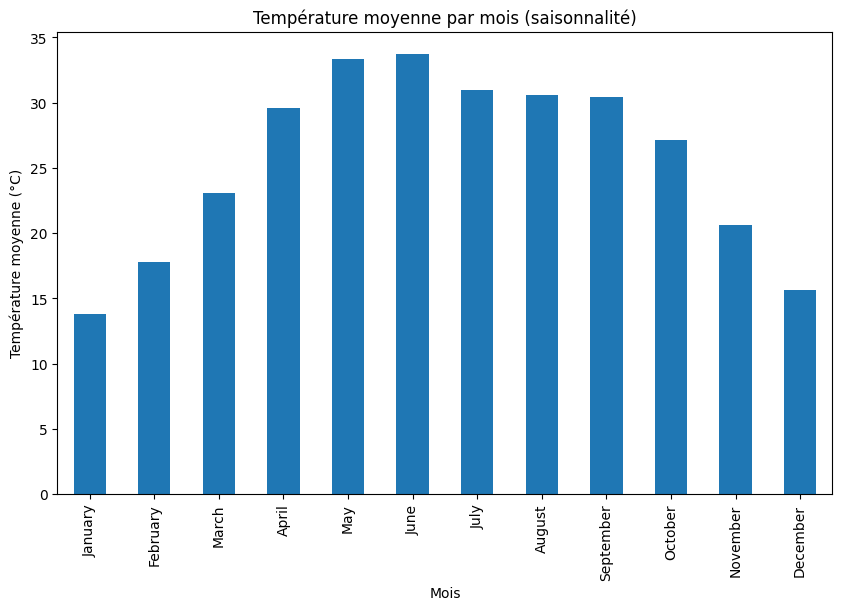

In [4]:
import matplotlib.pyplot as plt

import calendar

global_df["date"] = pd.to_datetime(global_df["date"])

global_df["month"] = global_df["date"].dt.month
monthly_avg = global_df.groupby("month")["meantemp"].mean()


plt.figure(figsize=(10, 6)) 

monthly_avg.plot(kind="bar")

plt.xticks(ticks=range(12), labels=[calendar.month_name[i+1] for i in range(12)])

plt.title("Température moyenne par mois (saisonnalité)")
plt.xlabel("Mois")
plt.ylabel("Température moyenne (°C)")
plt.show()

Les températures sont les plus basses en hiver (janvier, décembre), augmentent progressivement au printemps, atteignent un maximum en mai-juin, puis redescendent vers l’automne et l’hiver.

**Notebook suivant : Prétraitement des données**

👉 [Aller au Notebook suivant](02_pretraitement_des_donnees.ipynb)
